# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*


## Kaggle Run Env

In [1]:
# %cd /kaggle/working/
# !rm -rf /kaggle/working/dynamics
# !git clone https://github.com/HuangYin0514/dynamics.git
# %cd /kaggle/working/dynamics/Burgers_Equation_v1

# import sys
# sys.path.append('/kaggle/input/dynamics/mysitepackages')

# !pip install pyDOE

## Libraries and Dependencies

In [2]:
import torch

from pyDOE import lhs
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from model import DNN
import random

In [3]:
def init_random_state():
    random_seed = 1234
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.cuda.manual_seed(random_seed)
    np.random.seed(random_seed)  # Numpy module.
    random.seed(random_seed)  # Python random module.

init_random_state()

def speedup_for_torch():
    torch.backends.cudnn.deterministic = True
    # speed up compution
    torch.backends.cudnn.benchmark = True

speedup_for_torch()

# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Physics-informed Neural Networks

In [4]:
# the physics-guided neural network
class PhysicsInformedNN:
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):

        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.layers = layers
        self.nu = nu

        # deep neural networks
        self.dnn = DNN(layers).to(device)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",  # can be "strong_wolfe"
        )

        if not torch.cuda.is_available():
            print("using cpu for optim...")
            self.optimizer = torch.optim.LBFGS(
                self.dnn.parameters(),
                lr=1.0,
                max_iter=5,
                max_eval=5,
                history_size=50,
                tolerance_grad=1e-5,
                tolerance_change=1.0 * np.finfo(float).eps,
                line_search_fn="strong_wolfe",  # can be "strong_wolfe"
            )

        self.iter = 0
        self.loss = []
        self.loss_u = []
        self.loss_f = []

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        """The pytorch autograd version of calculating residual"""
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x,
            x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
        )[0]

        f = u_t + u * u_x - self.nu * u_xx
        return f

    def loss_func(self):
        self.optimizer.zero_grad()

        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)

        loss = loss_u + loss_f

        loss.backward()
        self.iter += 1
        

        if self.iter % 100 == 0:
            
            self.loss.append(loss.item())
            self.loss_u.append(loss_u.item())
            self.loss_f.append(loss_f.item())
            
            print(
                "Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e"
                % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss

    def train(self):
        self.dnn.train()

        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f


## Configurations For Data

In [5]:
nu = 0.01 / np.pi
noise = 0.0

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat("data/burgers_shock.mat")
Exact = np.real(data["usol"]).T

lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1.0])  # (X,T)
    
n_t = 100
n_x = 256

t = np.linspace(lb[1], ub[1], n_t).flatten()[:, None]
x = np.linspace(lb[0], ub[0], n_x).flatten()[:, None]

X, T = np.meshgrid(x, t)  # X(n_t,n_x) T(n_t,n_x)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # (n_x*n_t, 2)
u_star = Exact.flatten()[:, None]

xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))  # 左
uu1 = -1 * np.sin(xx1 * np.pi)[:, 0][:, None]
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))  # 下
uu2 = np.zeros([n_t, 1])
xx3 = np.hstack((X[:, -1:], T[:, -1:]))  # 上
uu3 = np.zeros([n_t, 1])

# all bounds constaints
X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

# pde constaints
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

# ib constraints
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx, :]


## Training

In [6]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

using cpu for optim...


In [7]:
%%time
               
model.train()

CPU times: user 5.51 s, sys: 1.44 s, total: 6.96 s
Wall time: 956 ms


In [8]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")
Error = np.abs(Exact - U_pred)


Error u: 1.014388e+00


## Visualizations

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

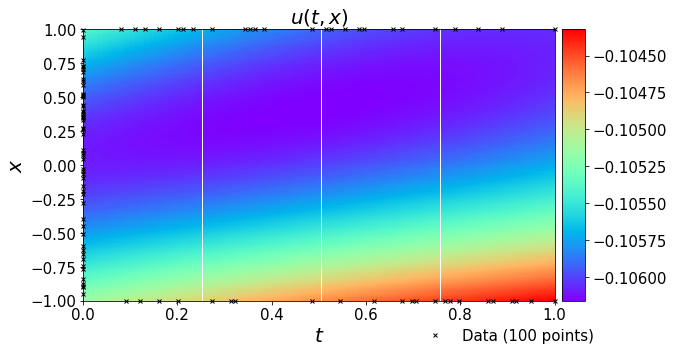

In [10]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


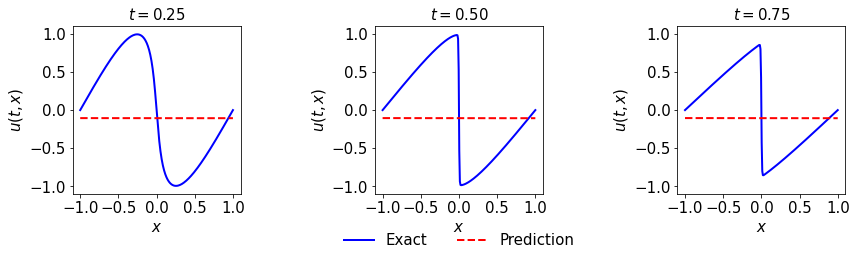

In [11]:

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

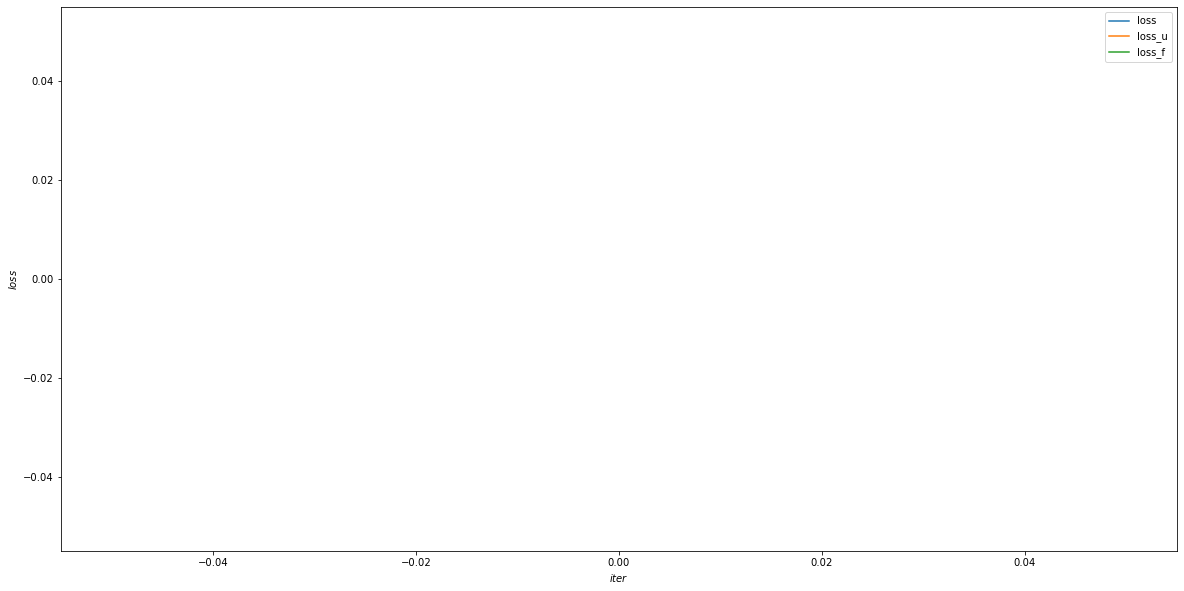

In [12]:
show_interval=0

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(model.loss[show_interval:], label="loss")
ax.plot(model.loss_u[show_interval:], label="loss_u")
ax.plot(model.loss_f[show_interval:], label="loss_f")
ax.set_xlabel('$iter$')
ax.set_ylabel('$loss$')
plt.legend()
plt.show()